In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statistics
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import keras
from keras.models import Sequential
from keras.layers import Dense

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
# Check virtual environment: should be: '/Users/James/anaconda3/envs/mimic/bin/python'
sys.executable

'/Users/James/anaconda3/envs/mimic/bin/python'

In [3]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

src_preparation_folder = os.path.join(src_folder, 'preparation')
src_processing_folder = os.path.join(src_folder, 'processing')
src_modeling_folder = os.path.join(src_folder, 'modeling')

In [4]:
# Import src functions
sys.path.insert(0, src_preparation_folder)
from import_data import get_table
from import_data import get_patient_admissions_diagnoses
from import_data import get_admission_data
from import_data import get_chartevents
from import_data import get_labevents
from extract_codes import find_ndc_codes

sys.path.insert(0, src_processing_folder)
from stats import plot_KDE
from stats import plot_perc_bar_chart
from stats import compare_groups
from stats import graph_comparisons
from patient_selection import select_test_groups
from clean import replace_itemid_with_label
from clean import find_populated_cols

sys.path.insert(0, src_modeling_folder)
from models import train_lgb

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
# Import chart/ lab events for all patients - final readings
chart_df = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', 'final_chart_and_lab_events.csv')), index_col=0)
chart_df = chart_df[['subject_id', 'hadm_id', 'dbsource', 'label', 'itemid', 'valuenum']]
chart_df['item_comb'] = chart_df['label'].astype(str) + ' - ' + chart_df['itemid'].astype(str) + ' - ' + chart_df['dbsource'].astype(str)

# Pivot - with 1 column per chart/ lab event
chart_df=pd.pivot_table(chart_df, values='valuenum', index=['subject_id', 'hadm_id', 'dbsource'], columns='item_comb')
chart_df=chart_df.reset_index()
chart_df['subject_id'] = chart_df['subject_id'].astype(int)
chart_df['hadm_id'] = chart_df['hadm_id'].astype(int)
chart_df.head()

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


item_comb,subject_id,hadm_id,dbsource,% Hemoglobin A1c - 50852 - lab,%cool mist - 3226 - carevue,02 ANALYZED - 6793 - carevue,1. Nausea and Vomit. - 1932 - carevue,1.Nausea &vomitting - 1922 - carevue,10% ALCOHOL CC/HR - 2876 - carevue,10% alcohol/ cc/hr - 2804 - carevue,...,xigris mcg/kg/hr - 2809 - carevue,xigris mg/hr - 1587 - carevue,xygris - 6110 - carevue,yi MV - 5902 - carevue,zzO2AV - 1401 - carevue,zzO2AVI - 1402 - carevue,zzz Stim Thresh mA [Value] - 8496 - carevue,zzzgth Calc (cm) - 4191 - carevue,zzzt Stim Thresh mA [Value] - 8497 - carevue,zzzzth in Centimeter - 4192 - carevue
0,2,163353,carevue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,163353,lab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,145834,carevue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,145834,lab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,185777,carevue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def select_patients_and_select_chartevents(diagnosis_id, diagnosis_name, events_frac, plot):
    
    print('=============')
    print(diagnosis_name)
    print('=============')
    
    df = select_test_groups(diagnosis = diagnosis_id,
                        first_diagnosis_only = True,
                        exclude_newborns = True,
                        exclude_deaths = True,
                        match_control = True,
                        show_stats_graphs = True)
    
    # Make a list of the cols to keep from the admissions df
    non_chart_cols = ['subject_id', 'hadm_id', 'target', 'gender', 'age_adm_bucket']
    
    # Merge on the chart events
    df = df[non_chart_cols]
    df = pd.merge(df, chart_df, how='left', left_on=['subject_id', 'hadm_id'], right_on=['subject_id', 'hadm_id'])
    
    # Only keep populated cols
    df = find_populated_cols(df, 'target', frac=events_frac)
    
    # De-dupe by admission to have lab and chart events on a single row
    df = (df.drop(columns='dbsource')
            .groupby(non_chart_cols)
            .max()
            .reset_index())
    
    if plot:
        # Plot a KDE for all remaining cols
        cols = [c for c in df.columns if c not in non_chart_cols]
        for c in cols:
            plot_KDE(df, 'target', 1, 0, c)
        
    df.to_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', 'chart_events_{}.csv'.format(diagnosis_name))))
    
    del df

acute_respiratory_failure
Original base group size: 29337
Sampled base group size: 23820
Subject group size: 4596


/Users/James/Desktop/YourMD/machine_learning/mimic/src/processing/stats.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(inplace=True)
/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


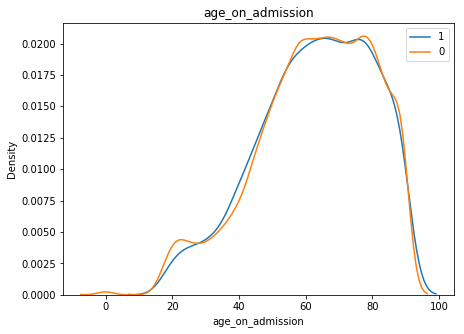

<Figure size 432x288 with 0 Axes>

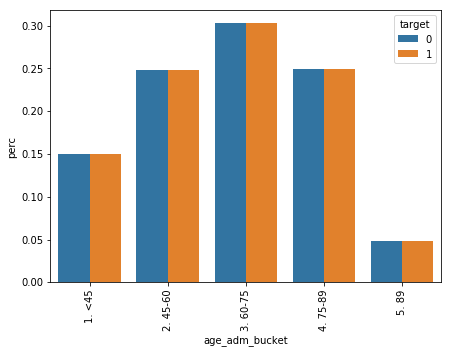

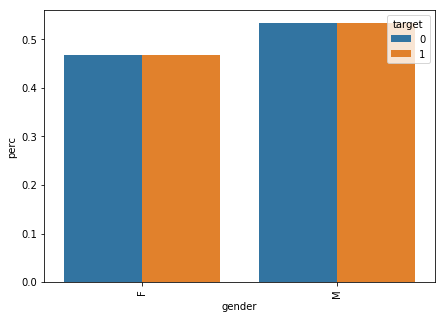

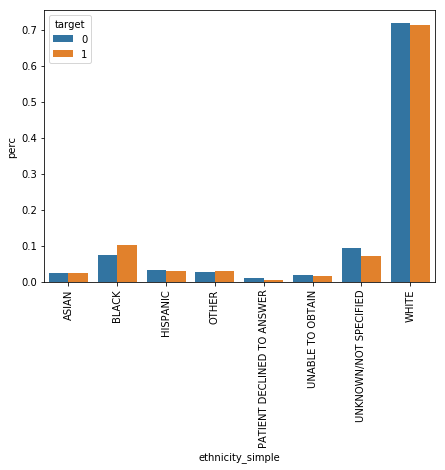

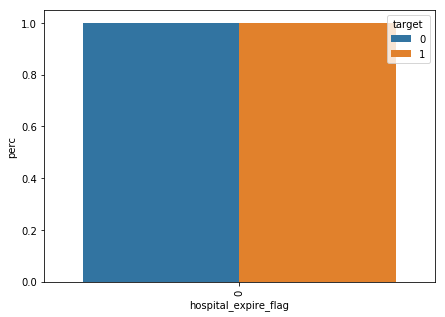

Original features: 3253
Features kept: 122
hypertension
Original base group size: 18381
Sampled base group size: 10287
Subject group size: 15866


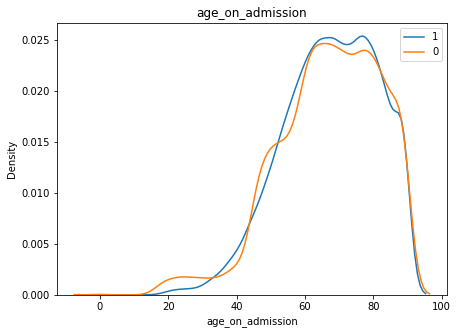

<Figure size 432x288 with 0 Axes>

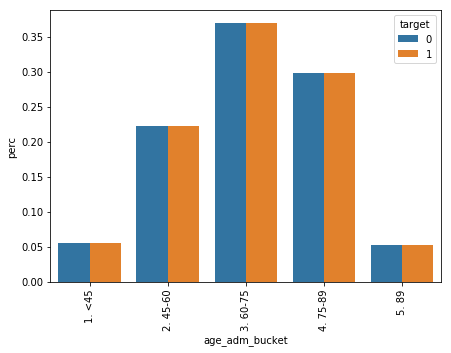

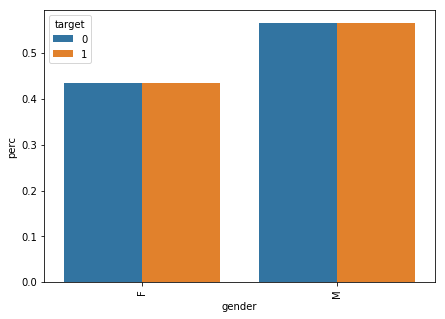

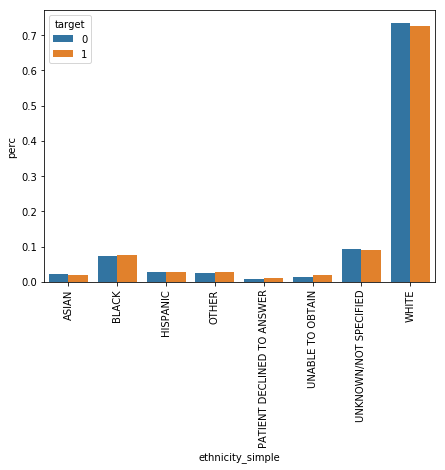

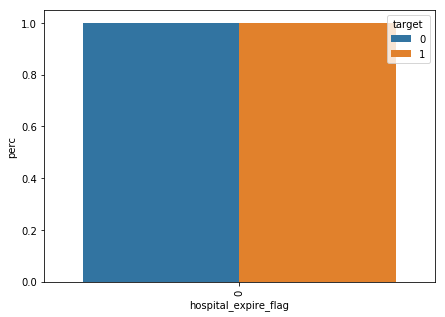

Original features: 3253
Features kept: 123
acute_kidney_failure
Original base group size: 27967
Sampled base group size: 9479
Subject group size: 6096


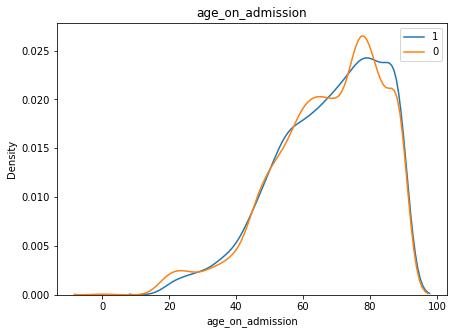

<Figure size 432x288 with 0 Axes>

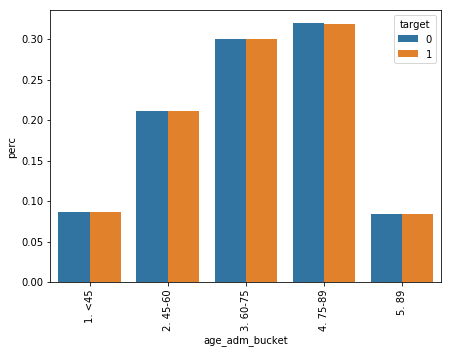

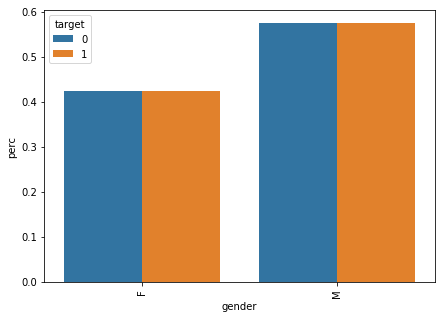

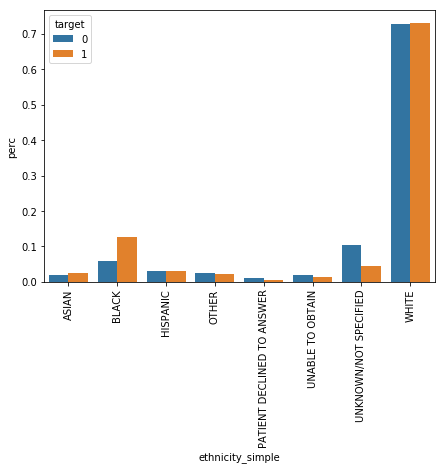

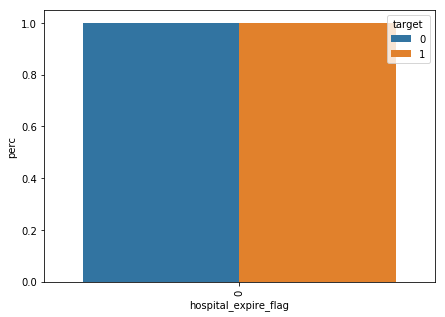

Original features: 3253
Features kept: 123
hyperlipidemia
Original base group size: 27361
Sampled base group size: 17635
Subject group size: 6916


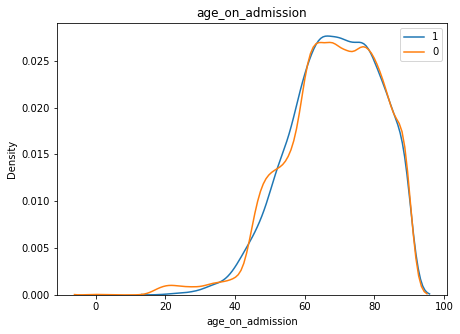

<Figure size 432x288 with 0 Axes>

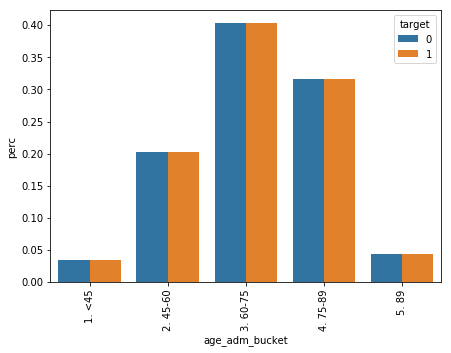

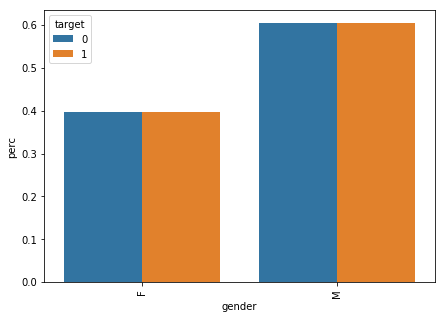

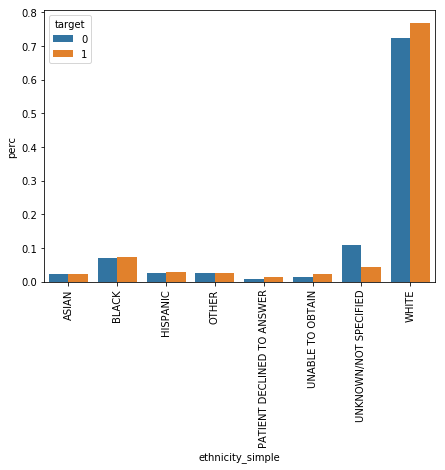

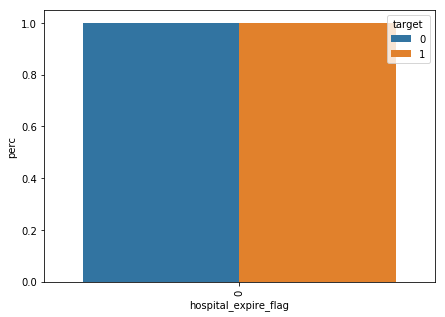

Original features: 3253
Features kept: 121
anemia
Original base group size: 29726
Sampled base group size: 20400
Subject group size: 4525


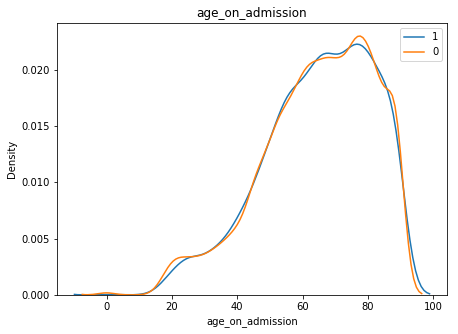

<Figure size 432x288 with 0 Axes>

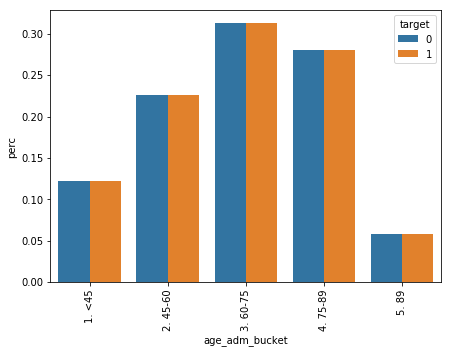

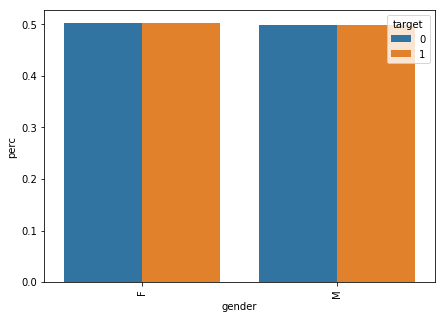

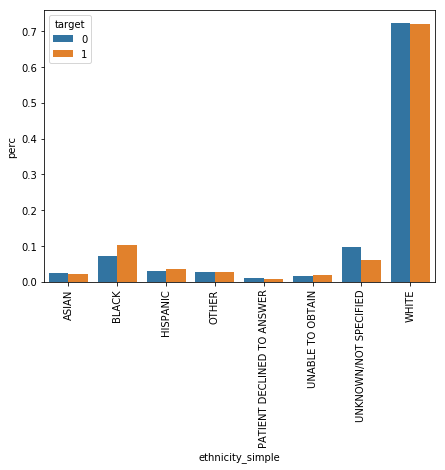

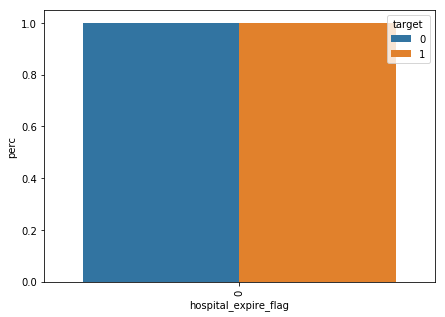

Original features: 3253
Features kept: 122
pneumonia
Original base group size: 30645
Sampled base group size: 15976
Subject group size: 3504


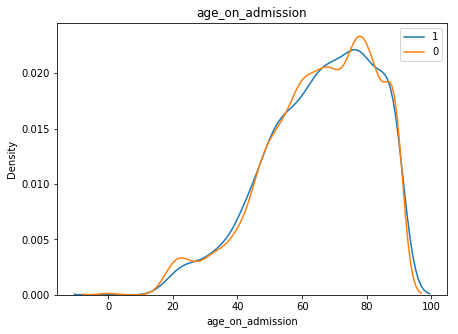

<Figure size 432x288 with 0 Axes>

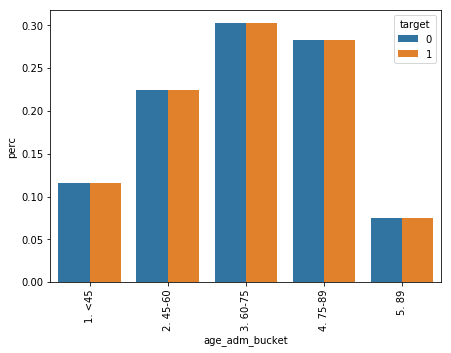

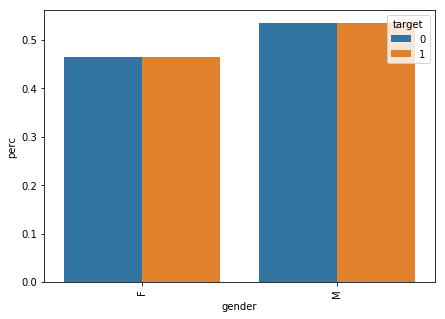

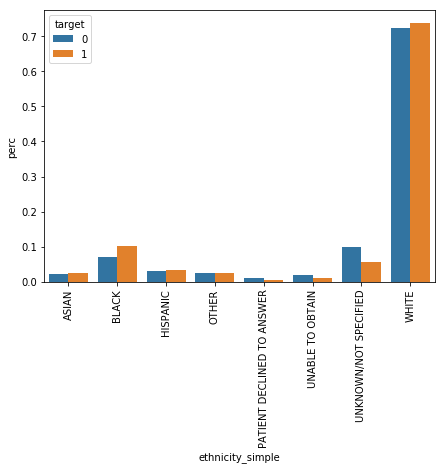

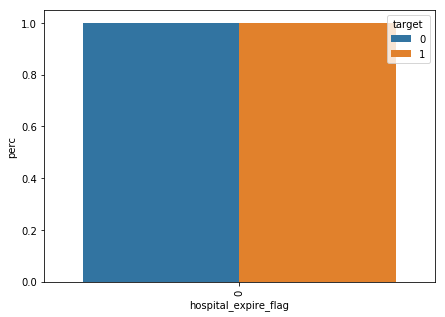

Original features: 3253
Features kept: 122
depression
Original base group size: 31617
Sampled base group size: 18792
Subject group size: 2700


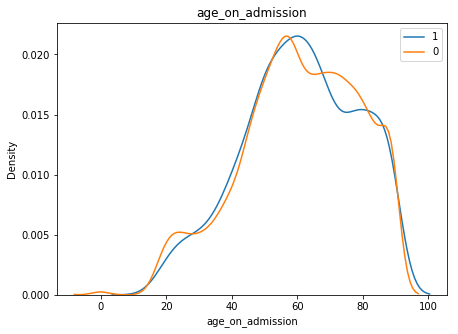

<Figure size 432x288 with 0 Axes>

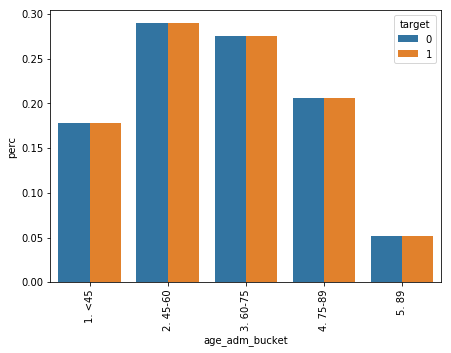

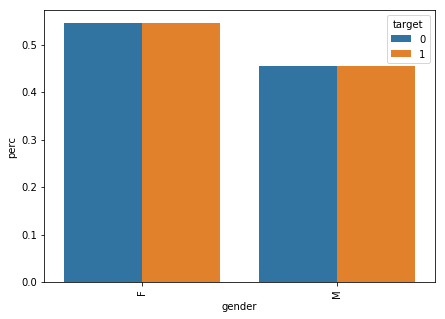

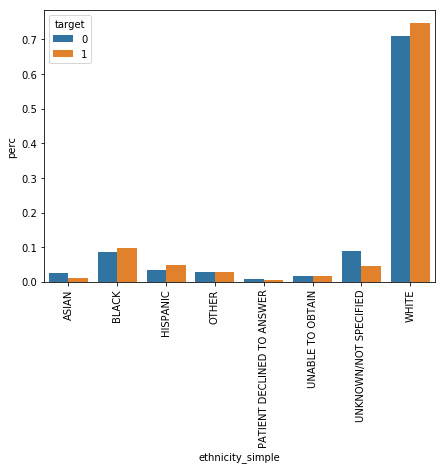

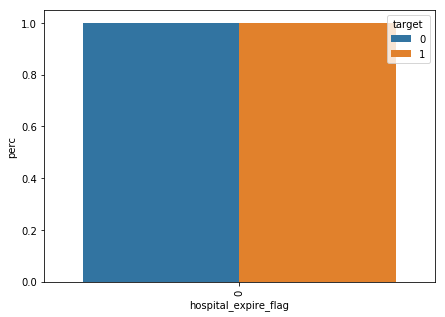

Original features: 3253
Features kept: 121
chronic_kidney_disease
Original base group size: 31743
Sampled base group size: 7752
Subject group size: 2517


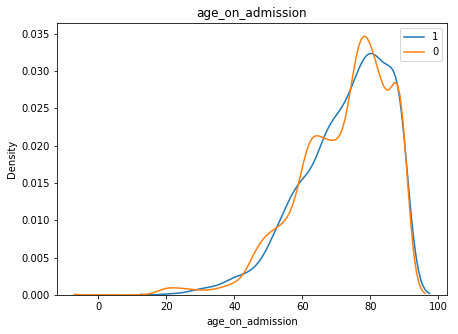

<Figure size 432x288 with 0 Axes>

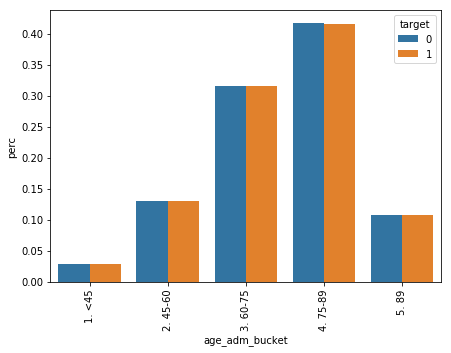

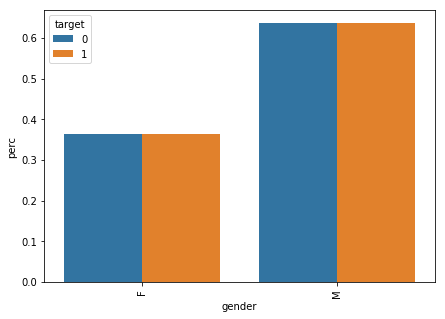

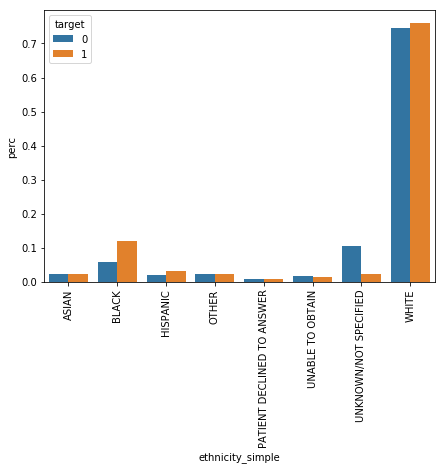

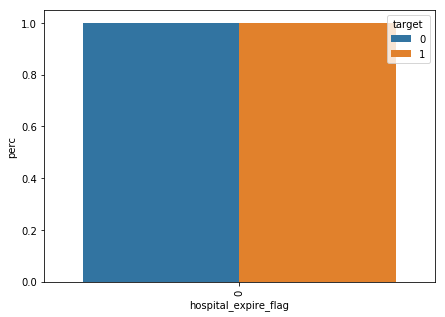

Original features: 3253
Features kept: 123


In [7]:
select_patients_and_select_chartevents('51881', 'acute_respiratory_failure', 0.75, plot=False)
select_patients_and_select_chartevents('4019', 'hypertension', 0.75, plot=False)
select_patients_and_select_chartevents('5849', 'acute_kidney_failure', 0.75, plot=False)
select_patients_and_select_chartevents('2724', 'hyperlipidemia', 0.75, plot=False)
select_patients_and_select_chartevents('2859', 'anemia', 0.75, plot=False)
select_patients_and_select_chartevents('486', 'pneumonia', 0.75, plot=False)
select_patients_and_select_chartevents('311', 'depression', 0.75, plot=False)
select_patients_and_select_chartevents('5859', 'chronic_kidney_disease', 0.75, plot=False)